# **GNNs**

## **Introduction**

In this notebook, we will be discussing Graph Neural Networks (GNNs). GNNs are a class of neural networks that are designed to work with graph data. They are used to learn the structure of the graph and make predictions based on the graph data. GNNs have been widely used in various applications such as social network analysis, recommendation systems, and bioinformatics.

For this notebook, we will be using the PyTorch Geometric library, which provides a set of utilities for working with graph data and implementing GNNs.

### Pre requisites

```yaml
Python Version: 3.10
``` 

To install `cuda`, follow the instructions at https://developer.nvidia.com/cuda-downloads

```sh
pip install torch_geometric
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 # Instalation with cuda
pip install scipy
pip install pandas
pip install matplotlib
pip install scikit-learn
```

## **Datasets chosen**

We chose three diverse datasets from PyTorch Geometric, each with notable differences in structure, task, and scale, which will help you analyze how a GNN model behaves across different types of data:

### 1. **Cora (Planetoid Dataset)**
   - **Type:** Citation network.
   - **Task:** Node classification.
   - **Description:** Nodes represent papers, and edges represent citation links between them.
   - **Features:** Each node has a 1433-dimensional feature vector based on word occurrences.
   - **Labels:** Seven classes representing different research topics.
   - **Graph Structure:** Sparse, single connected graph.

   **Key Aspect:** Ideal for understanding how a GNN handles a small, well-connected citation network with clear feature vectors.

### 2. **Citeseer (Planetoid Dataset)**
   - **Type:** Citation network.
   - **Task:** Node classification.
   - **Description:** Nodes represent scientific publications, and edges represent citation links between them.
   - **Features:** Each node has a 3703-dimensional feature vector based on word occurrences.
   - **Labels:** Six classes representing different research topics.
   - **Graph Structure:** Sparse, single connected graph.

   **Key Aspect:** Useful for evaluating how GNNs manage semi-structured citation networks with more complex feature spaces compared to Cora.


### 3. **PubMed (Planetoid Dataset)**
   - **Type:** Citation network.
   - **Task:** Node classification.
   - **Description:** Nodes represent scientific publications in the field of medicine, and edges represent citation links between them.
   - **Features:** Each node has a 500-dimensional feature vector based on Term Frequency-Inverse Document Frequency (TF-IDF) of words.
   - **Labels:** Three classes representing different types of diabetes research.
   - **Graph Structure:** Sparse, single connected graph.

   **Key Aspect:** Demonstrates how GNNs perform on large-scale citation networks with lower-dimensional but more concise feature representations.

### Comparison and Analysis
- **Cora:** Focuses on node classification within a small, well-connected academic citation network.
- **Citeseer:** Highlights node classification in a citation network with more complex feature spaces and a larger feature dimension.
- **PubMed:** Examines node classification in a larger-scale medical citation network with concise feature vectors and fewer classes.

These datasets offer a balanced mix of graph sizes and complexities, making them ideal for evaluating node classification models across various tasks and graph structures.


## **Dataset load**

In [4]:
from torch_geometric.datasets import Planetoid

def load_datasets():
    cora = Planetoid(root='/tmp/Cora', name='Cora')
    citeSeer = Planetoid(root='/tmp/CiteSeer', name='CiteSeer')
    pubMed = Planetoid(root='/tmp/PubMed', name='PubMed')

    return cora, citeSeer, pubMed

## **Data Preprocessing**

These datasets are already preprocessed and ready to use in PyTorch Geometric. If you want to preprocess your own dataset, you can choose those datasets but in raw format.

## **Model Selection**

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

n_epochs = 100

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation='relu', dropout=0.0):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.activation = activation
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x) if self.activation == 'relu' else F.tanh(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1) if data.y.dtype == torch.long else x

## **Model Training**

In [6]:
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) if data.y.dtype == torch.long else F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

## **Model Evaluation**

In [7]:
from sklearn.metrics import classification_report, accuracy_score
def evaluate_node_classification(model, data, isTrain=False, finished=False):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    y_pred, y_true = [], []
    if isTrain:
        y_true = data.y[data.train_mask].cpu().numpy()
        y_pred = pred[data.train_mask].cpu().numpy()
    else:
        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()
    if finished:
        print(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

### **Plotting Loss and Accuracy**

In [8]:
import matplotlib.pyplot as plt

def plot_loss_accuracy_curve(relu_losses, relu_accuracies, tanh_losses, tanh_accuracies, relu_train_accuracies, tanh_train_accuracies, name=''):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), relu_losses, label='ReLU Loss', color='blue')
    plt.plot(range(1, n_epochs + 1), tanh_losses, label='Tanh Loss', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), relu_accuracies, label='ReLU Test Accuracy', color='blue')
    plt.plot(range(1, n_epochs + 1), tanh_accuracies, label='Tanh Test Accuracy', color='green')
    plt.plot(range(1, n_epochs + 1), relu_train_accuracies, label='ReLU Train Accuracy', linestyle='--', color='blue')
    plt.plot(range(1, n_epochs + 1), tanh_train_accuracies, label='Tanh Train Accuracy', linestyle='--', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train/Test Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    if name != '':
        plt.savefig(name + '_loss_accuracy_curve.png')
    plt.show()


In [9]:
def plot_dropout_accuracy_curve(dropout_accuracies, name=''):
    # Plot the results
    plt.figure(figsize=(12, 5))

    for dropout, accuracies in dropout_accuracies.items():
        plt.plot(range(1, n_epochs + 1), accuracies, label=f'Dropout {dropout}', linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Over Epochs with Different Dropout Rates')
    plt.legend()
    if name != '':
        plt.savefig(name + '_dropout_accuracy_curve.png')
    plt.show()

## **Experiments**

In [10]:
from torch_geometric.data import DataLoader

cora, citeSeer, pubMed = load_datasets()

### **ReLu vs Tanh**

In [11]:
def relu_tanh_comparison(dataset):
    model_relu = GCN(dataset.num_features, 16, dataset.num_classes, activation='relu', dropout=0.5)
    model_tanh = GCN(dataset.num_features, 16, dataset.num_classes, activation='tanh', dropout=0.5)

    optimizer_relu = torch.optim.Adam(model_relu.parameters(), lr=0.01, weight_decay=5e-4)
    optimizer_tanh = torch.optim.Adam(model_tanh.parameters(), lr=0.01, weight_decay=5e-4)

    train_losses_relu, test_accuracies_relu = [], []
    train_losses_tanh, test_accuracies_tanh = [], []
    train_accuracies_relu, train_accuracies_tanh = [], []

    for epoch in range(1, n_epochs + 1):
        train_loss_relu = train(model_relu, dataset, optimizer_relu)
        train_losses_relu.append(train_loss_relu)
        train_accuracy_relu = evaluate_node_classification(model_relu, dataset, isTrain=True)
        train_accuracies_relu.append(train_accuracy_relu)
        test_accuracy_relu = evaluate_node_classification(model_relu, dataset)
        test_accuracies_relu.append(test_accuracy_relu)

        train_loss_tanh = train(model_tanh, dataset, optimizer_tanh)
        train_losses_tanh.append(train_loss_tanh)
        train_accuracy_tanh = evaluate_node_classification(model_tanh, dataset, isTrain=True)
        train_accuracies_tanh.append(train_accuracy_tanh)
        test_accuracy_tanh = evaluate_node_classification(model_tanh, dataset)
        test_accuracies_tanh.append(test_accuracy_tanh)

    return train_losses_relu, test_accuracies_relu, train_losses_tanh, test_accuracies_tanh, train_accuracies_relu, train_accuracies_tanh


#### Cora Dataset

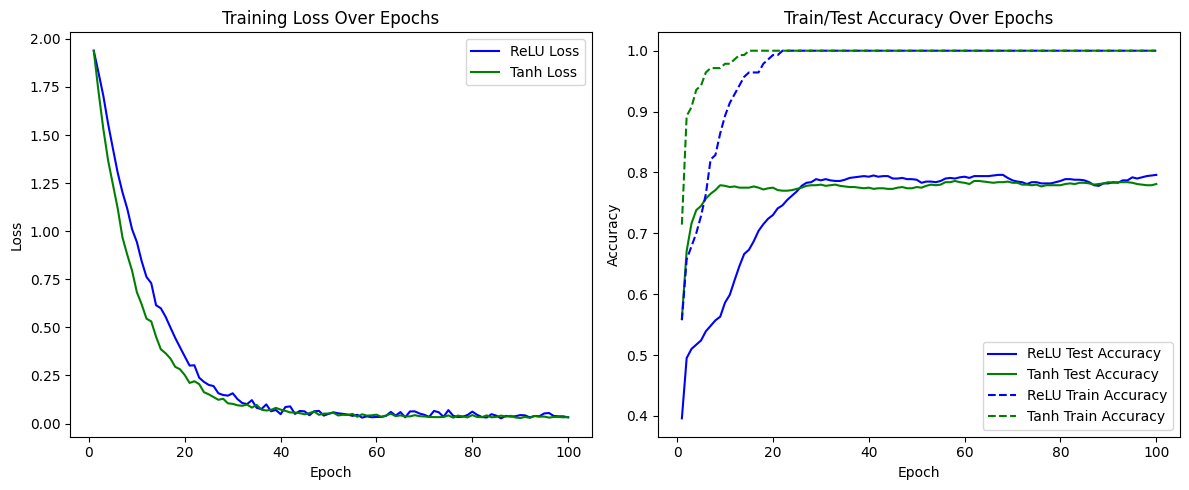

In [12]:
relu_losses, relu_accuracies, tanh_losses, tanh_accuracies, relu_train_accuracies, tanh_train_accuracies = relu_tanh_comparison(cora)

# Plot both ReLU and Tanh results on the same graphs
plot_loss_accuracy_curve(relu_losses, relu_accuracies, tanh_losses, tanh_accuracies, relu_train_accuracies, tanh_train_accuracies, name='cora')

#### Citeseer Dataset

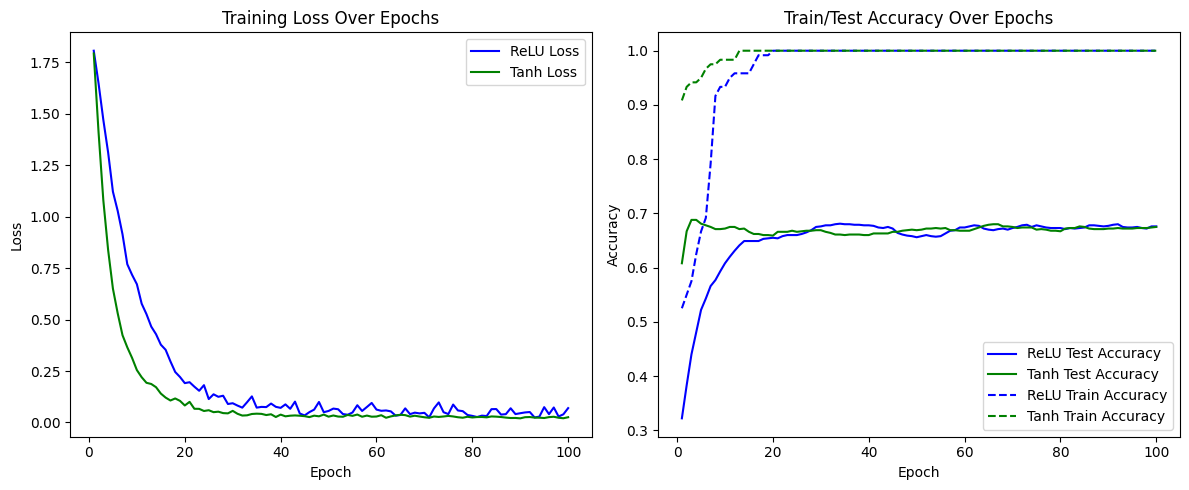

In [13]:
relu_losses, relu_accuracies, tanh_losses, tanh_accuracies, relu_train_accuracies, tanh_train_accuracies = relu_tanh_comparison(citeSeer)

# Plot both ReLU and Tanh results on the same graphs
plot_loss_accuracy_curve(relu_losses, relu_accuracies, tanh_losses, tanh_accuracies, relu_train_accuracies, tanh_train_accuracies, name='citeSeer')

#### PubMed Dataset

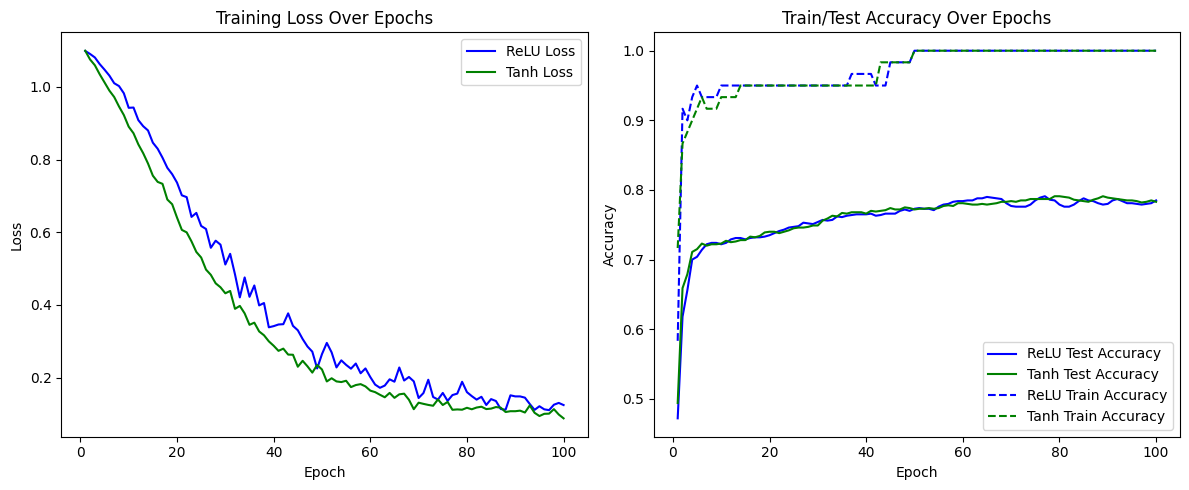

In [14]:
relu_losses, relu_accuracies, tanh_losses, tanh_accuracies, relu_train_accuracies, tanh_train_accuracies = relu_tanh_comparison(pubMed)

# Plot both ReLU and Tanh results on the same graphs
plot_loss_accuracy_curve(relu_losses, relu_accuracies, tanh_losses, tanh_accuracies, relu_train_accuracies, tanh_train_accuracies, name='pubMed')

### **Dropout**

In [15]:
def dropout_comparison(dataset):
    dropout_accuracies = {}
    for dropout in [0.1, 0.3, 0.5, 0.7, 0.9]:
        model = GCN(dataset.num_features, 16, dataset.num_classes, activation='relu', dropout=dropout)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

        accuracies = []
        for epoch in range(1, n_epochs + 1):
            train(model, dataset, optimizer)
            accuracy = evaluate_node_classification(model, dataset)
            accuracies.append(accuracy)

        dropout_accuracies[dropout] = accuracies

    return dropout_accuracies

#### Cora Dataset

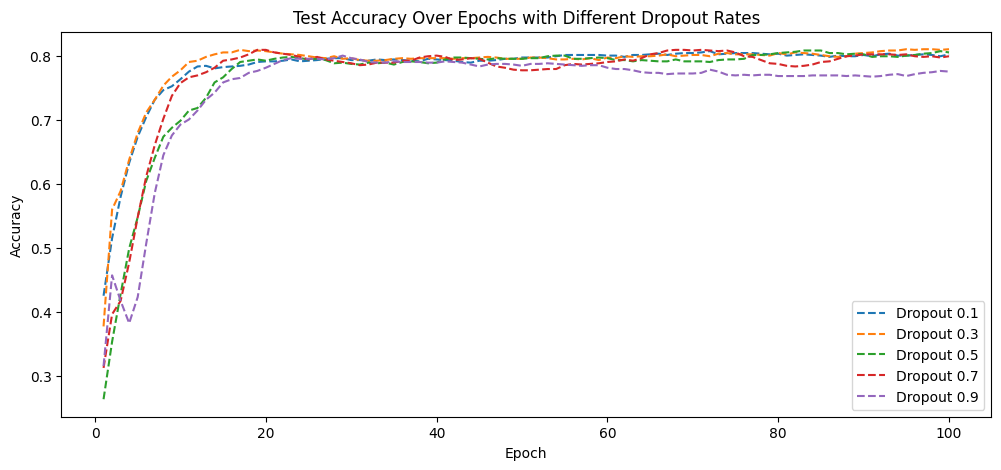

In [16]:
dropout_accuracies = dropout_comparison(cora)

plot_dropout_accuracy_curve(dropout_accuracies, name='cora')

#### Citeseer Dataset

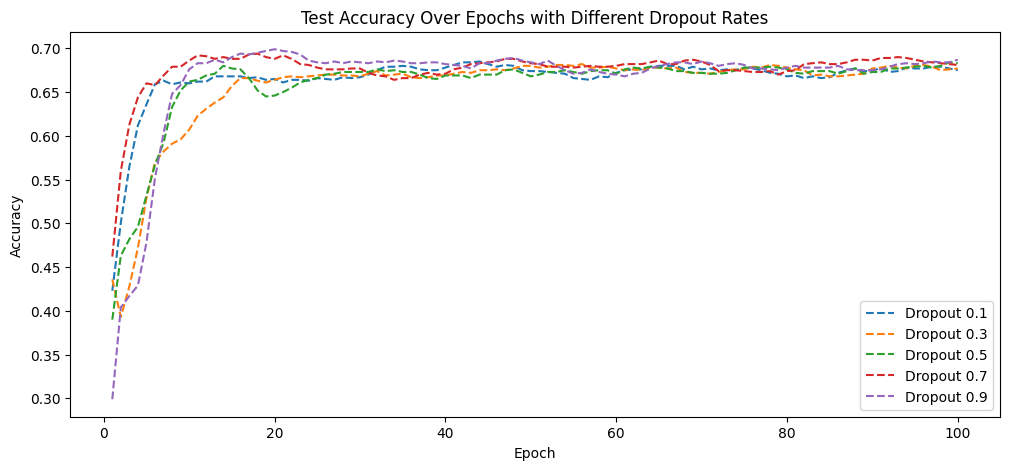

In [17]:
dropout_accuracies = dropout_comparison(citeSeer)

plot_dropout_accuracy_curve(dropout_accuracies, name='citeSeer')

#### PubMed Dataset

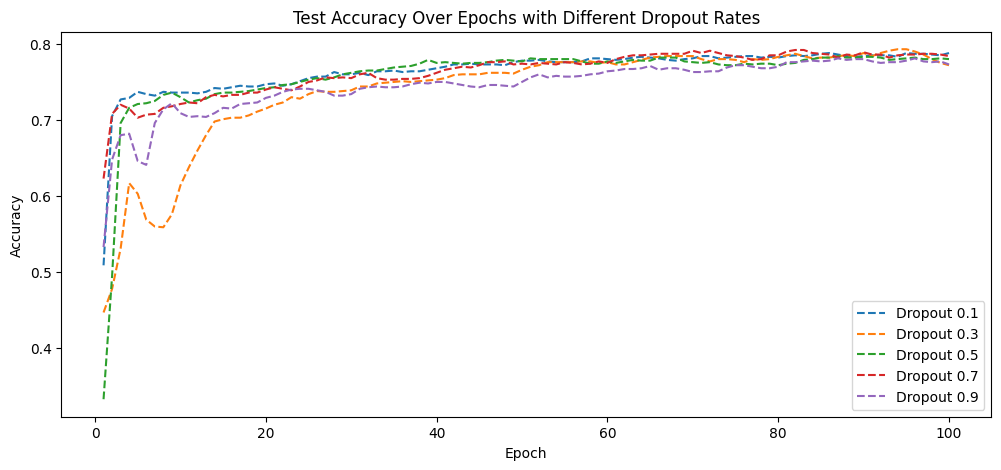

In [18]:
dropout_accuracies = dropout_comparison(pubMed)

plot_dropout_accuracy_curve(dropout_accuracies, name='pubMed')

### **CUDA**

In [19]:
import torch
import time

cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")
print("CUDA Version:", torch.version.cuda)

def benchmark(loader, model, device):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
    end_time = time.time()
    return end_time - start_time

import numpy as np

def plot_size_vs_time(dataset_sizes, cpu_times, gpu_times, name=''):
     # Convert to numpy arrays
    dataset_sizes = np.array(dataset_sizes)
    cpu_times = np.array(cpu_times)
    gpu_times = np.array(gpu_times) if gpu_times is not None else None
    
    # Set up the figure
    plt.figure(figsize=(12, 8))
    
    # Bar width and positions
    bar_width = 0.35
    indices = np.arange(len(dataset_sizes))
    
    # Bar chart for CPU
    plt.bar(indices, cpu_times, bar_width, label='CPU', color='steelblue', edgecolor='black')
    
    # Bar chart for GPU
    if gpu_times is not None:
        plt.bar(indices + bar_width, gpu_times, bar_width, label='GPU', color='seagreen', edgecolor='black')
    
    # Add labels and title
    plt.xlabel('Dataset Size (MB)', fontsize=14, fontweight='bold')
    plt.ylabel('Time (seconds)', fontsize=14, fontweight='bold')
    plt.title('Dataset Size vs Time (CPU vs GPU)', fontsize=16, fontweight='bold')
    
    # Adjust X-axis labels to rotate and avoid overlapping, apply rounding
    plt.xticks(indices + (bar_width / 2), [f"{round(size, 2)} MB" for size in dataset_sizes], fontsize=12, rotation=45, ha='right')
    
    # Add legend
    plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True, facecolor='white')
    
    # Add grid lines
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    
    # Tight layout to adjust spacing
    plt.tight_layout()
    
    # Save the plot if name is provided
    if name != '':
        plt.savefig(f"{name}_benchmark_fixed.png", dpi=300)

    # Show the plot
    plt.show()

CUDA Available: True
CUDA Version: 12.1


In [20]:
def cpu_gpu_benchmark(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model = GCN(dataset.num_features, 16, dataset.num_classes, activation='relu', dropout=0.5)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    # Run on CPU
    device = torch.device('cpu')
    model = model.to(device)
    cpu_time = benchmark(loader, model, device)
    gpu_time = 0
    # Run on GPU
    if torch.cuda.is_available():
        device = torch.device('cuda')
        model = model.to(device)
        gpu_time = benchmark(loader, model, device)
        print(f"CPU Time: {cpu_time:.2f}s, GPU Time: {gpu_time:.2f}s")
    else:
        print("CUDA is not available. Only CPU test run.")
    return cpu_time, gpu_time

In [21]:
from torch_geometric.datasets import Coauthor, Amazon, PPI, Reddit
import os

coauthor_cs = Coauthor(root='/tmp/CoauthorCS', name='cs')
coauthor_phy = Coauthor(root='/tmp/CoauthorPHY', name='physics')
computers = Amazon(root='/tmp/Computers', name='Computers')
ppi = PPI(root='/tmp/PPI')
ppi.name = 'PPI'
# reddit = Reddit(root='/tmp/Reddit')
# reddit.name = 'Reddit'

datasets =      [cora, citeSeer, pubMed, coauthor_cs, coauthor_phy, computers, ppi]
dataset_paths = [cora.raw_dir, citeSeer.raw_dir, pubMed.raw_dir, coauthor_cs.raw_dir, coauthor_phy.raw_dir, computers.raw_dir, ppi.raw_dir]
dataset_sizes = []

for dataset, dataset_path in zip(datasets, dataset_paths):
    # Get the size of the dataset folder in bytes
    dataset_size = sum(os.path.getsize(os.path.join(dataset_path, f)) for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f)))

    # Convert bytes to MB
    dataset_size_mb = dataset_size / (1024 * 1024)
    dataset_sizes.append(dataset_size_mb)

    print(f"{dataset.name} size: {dataset_size_mb:.2f} MB")

Cora size: 0.55 MB
CiteSeer size: 0.99 MB
PubMed size: 8.32 MB
CS size: 12.24 MB
Physics size: 15.62 MB
computers size: 30.44 MB
PPI size: 130.61 MB


c:\Users\diogo\anaconda3\envs\taia-python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


CPU Time: 0.01s, GPU Time: 0.39s
CPU Time: 0.01s, GPU Time: 0.02s
CPU Time: 0.02s, GPU Time: 0.01s
CPU Time: 0.13s, GPU Time: 0.11s
CPU Time: 0.35s, GPU Time: 0.35s
CPU Time: 0.05s, GPU Time: 0.02s
CPU Time: 0.26s, GPU Time: 0.02s


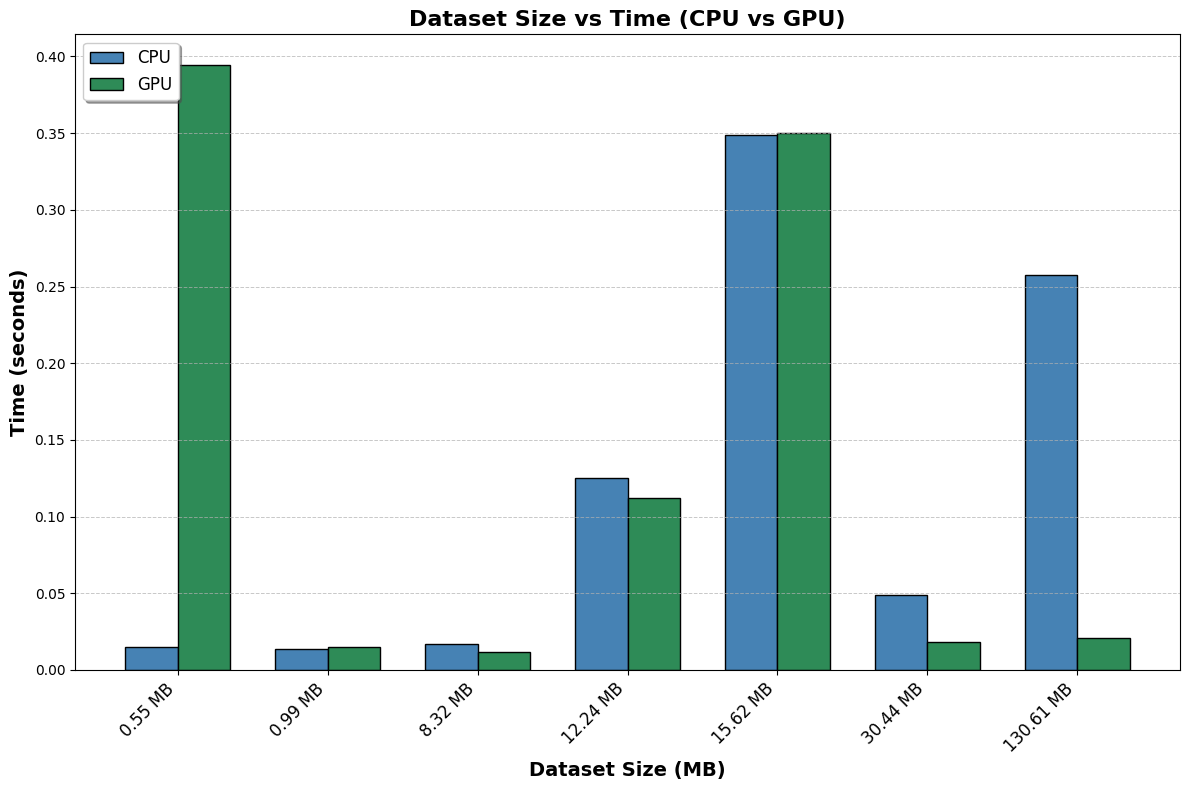

In [22]:
cpu_times, gpu_times = [], []
for dataset in datasets:
    cpu_time, gpu_time = cpu_gpu_benchmark(dataset)
    cpu_times.append(cpu_time)
    gpu_times.append(gpu_time)
plot_size_vs_time(dataset_sizes, cpu_times, gpu_times, name='cpu_gpu')